# **Install libraries**

In [ ]:
#  Install necessary libraries
!pip install -q segmentation-models-pytorch albumentations pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.7 MB/s eta 0:00:00


# **Imports**

In [ ]:

import os, json, torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools import mask as maskUtils
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# **Setup device**

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


# **Mount and unzip dataset**

In [ ]:

# from google.colab import files
# uploaded = files.upload()

import zipfile
zip_path = "/content/RM_Segmentation_Assignment_dataset.zip"
extract_path = "/content/dataset"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted:", os.listdir(extract_path))

Extracted: ['validation-300', 'train-300', 'test-30']


# **EDA: Visual inspection and image-mask structure**

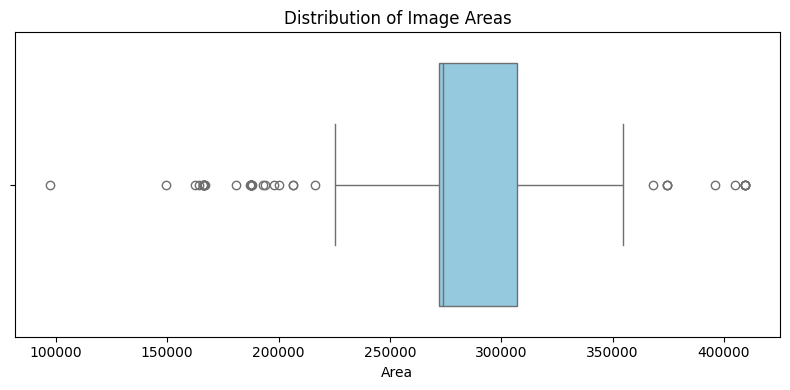

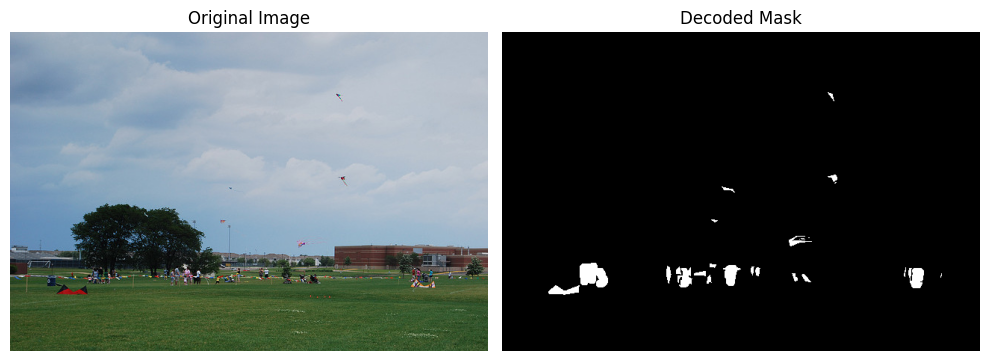

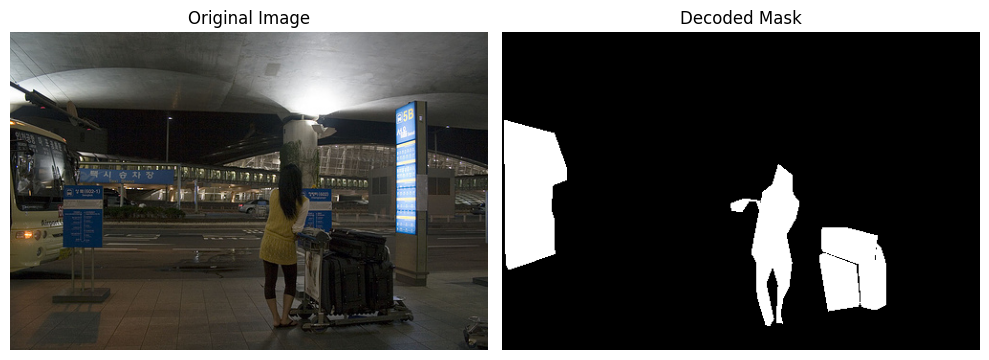

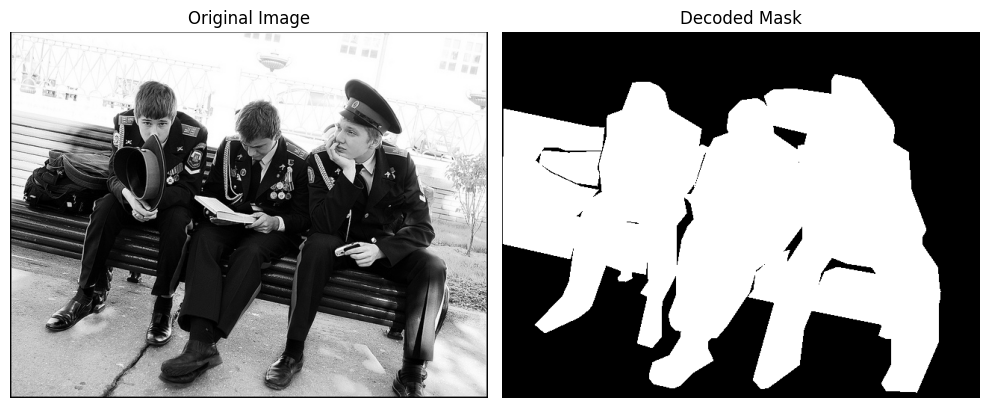

✅ Unique pixel values in masks (first 10 images): {np.uint8(0), np.uint8(1)}
📦 Total images: 300, 📎 Total annotations: 3870


In [ ]:
# 📊 EDA: Visual inspection and image-mask structure
import cv2
import seaborn as sns
import pandas as pd

# Load JSON for training set
eda_json_path = os.path.join(extract_path, "train-300/labels.json")
eda_img_dir = os.path.join(extract_path, "train-300/data")

with open(eda_json_path) as f:
    eda_coco = json.load(f)

eda_images = eda_coco['images']
eda_anns = eda_coco['annotations']

# Area distribution
image_sizes = [img['height'] * img['width'] for img in eda_images]
df_sizes = pd.DataFrame({'ImageID': [img['id'] for img in eda_images], 'Area': image_sizes})

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_sizes, x="Area", color="skyblue")
plt.title("Distribution of Image Areas")
plt.tight_layout()
plt.show()

# Show 3 image + decoded mask overlays
def decode_coco_mask(image_id, annotations, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)
    for ann in annotations:
        if ann['image_id'] == image_id:
            seg = ann['segmentation']
            rle = maskUtils.frPyObjects(seg, height, width)
            rle = maskUtils.merge(rle) if isinstance(rle, list) else rle
            decoded = maskUtils.decode(rle)
            if decoded.ndim == 3:
                decoded = decoded[:, :, 0]
            mask = np.maximum(mask, decoded)
    return mask

# Visualize samples
for i in range(3):
    img_info = eda_images[i]
    img_path = os.path.join(eda_img_dir, img_info['file_name'])
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = decode_coco_mask(img_info['id'], eda_anns, img_info['height'], img_info['width'])

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Decoded Mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Mask value check
mask_values = set()
for img in eda_images[:10]:
    m = decode_coco_mask(img['id'], eda_anns, img['height'], img['width'])
    mask_values.update(np.unique(m))

print(f" Unique pixel values in masks (first 10 images): {mask_values}")
print(f" Total images: {len(eda_images)}, 📎 Total annotations: {len(eda_anns)}")


# **Custom Dataset Class**

In [ ]:
from torch.utils.data import Dataset
import os
import numpy as np
import torch
from PIL import Image
from pycocotools import mask as maskUtils
import json

# Updated target classes
TARGET_CLASS_NAMES = ['cake', 'car', 'dog', 'person']

class COCOFormattedDataset(Dataset):
    def __init__(self, img_dir, json_path, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load COCO-style JSON
        with open(json_path, 'r') as f:
            coco = json.load(f)

        self.images = coco['images']
        self.annotations = coco['annotations']
        self.categories = coco['categories']

        # Map category_id to category_name
        self.cat_id_to_name = {cat['id']: cat['name'] for cat in self.categories}

        # Filter annotations to only those in target classes
        self.filtered_anns = [
            ann for ann in self.annotations
            if self.cat_id_to_name[ann['category_id']] in TARGET_CLASS_NAMES
        ]

        # Group annotations by image_id
        self.id_to_anns = {}
        for ann in self.filtered_anns:
            self.id_to_anns.setdefault(ann['image_id'], []).append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        info = self.images[idx]
        image_id = info['id']
        img_path = os.path.join(self.img_dir, info['file_name'])

        # Load image
        image = np.array(Image.open(img_path).convert("RGB"))
        h, w = info['height'], info['width']

        # Initialize empty binary mask
        mask = np.zeros((h, w), dtype=np.uint8)

        # Decode segmentation masks for relevant annotations
        for ann in self.id_to_anns.get(image_id, []):
            seg = ann.get('segmentation', [])
            if isinstance(seg, list) and len(seg) > 0:
                try:
                    rle = maskUtils.frPyObjects(seg, h, w)
                    rle = maskUtils.merge(rle)
                    decoded = maskUtils.decode(rle)
                    if decoded.ndim == 3:
                        decoded = decoded[:, :, 0]
                    mask = np.maximum(mask, decoded)
                except Exception as e:
                    print(f"Skipping annotation {ann.get('id')} in image {image_id}: {e}")
                    continue

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'].float() / 255.0
            mask = (augmented['mask'] > 0).unsqueeze(0).float()
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask


# **Load Data**

In [ ]:

import albumentations as A
from albumentations.pytorch import ToTensorV2

#  No normalization in train/val transforms
train_tfms = A.Compose([
    A.RandomCrop(256, 256),
    A.HorizontalFlip(),
    A.ColorJitter(p=0.3),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])


#  Paths
train_images = f"{extract_path}/train-300/data"
train_labels = f"{extract_path}/train-300/labels.json"
val_images = f"{extract_path}/validation-300/data"
val_labels = f"{extract_path}/validation-300/labels.json"

# Datasets and loaders
train_ds = COCOFormattedDataset(train_images, train_labels, train_tfms)
val_ds = COCOFormattedDataset(val_images, val_labels, val_tfms)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)


# **Model Training**

In [ ]:
#  Model: PSPNet with ResNet50
model = smp.PSPNet(encoder_name="resnet50", encoder_weights="imagenet", classes=1, activation=None).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []

for epoch in range(10):
    model.train()
    train_loss = 0
    for imgs, masks in train_dl:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item() * imgs.size(0)

    avg_train = train_loss / len(train_dl.dataset)
    avg_val = val_loss / len(val_dl.dataset)
    train_losses.append(avg_train)
    val_losses.append(avg_val)
    print(f"Epoch {epoch+1}/10 ➤ Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1/10 ➤ Train Loss: 0.5285 | Val Loss: 0.4409
Epoch 2/10 ➤ Train Loss: 0.5034 | Val Loss: 0.3797
Epoch 3/10 ➤ Train Loss: 0.5159 | Val Loss: 0.3570
Epoch 4/10 ➤ Train Loss: 0.4715 | Val Loss: 0.3791
Epoch 5/10 ➤ Train Loss: 0.4389 | Val Loss: 0.3500
Epoch 6/10 ➤ Train Loss: 0.4669 | Val Loss: 0.4570
Epoch 7/10 ➤ Train Loss: 0.4154 | Val Loss: 0.3581
Epoch 8/10 ➤ Train Loss: 0.4499 | Val Loss: 0.5880
Epoch 9/10 ➤ Train Loss: 0.4362 | Val Loss: 0.4771
Epoch 10/10 ➤ Train Loss: 0.4114 | Val Loss: 0.3617


# Visualization

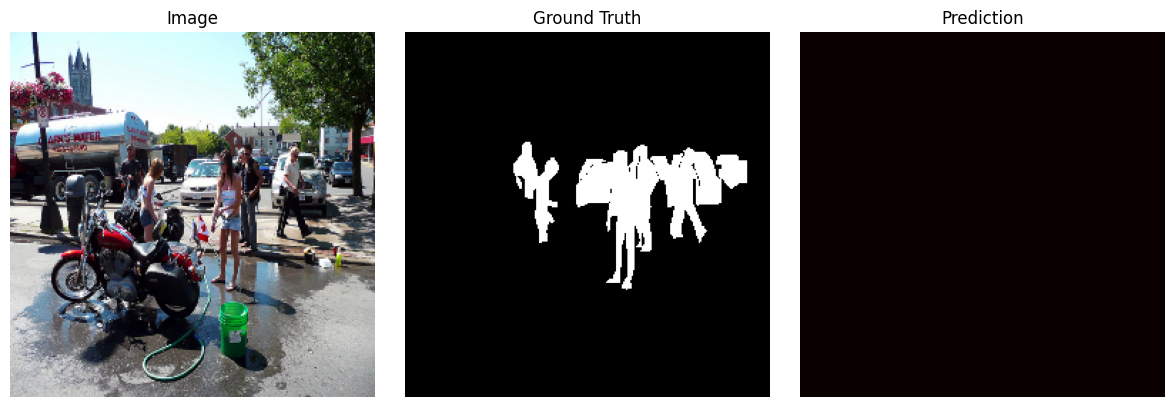

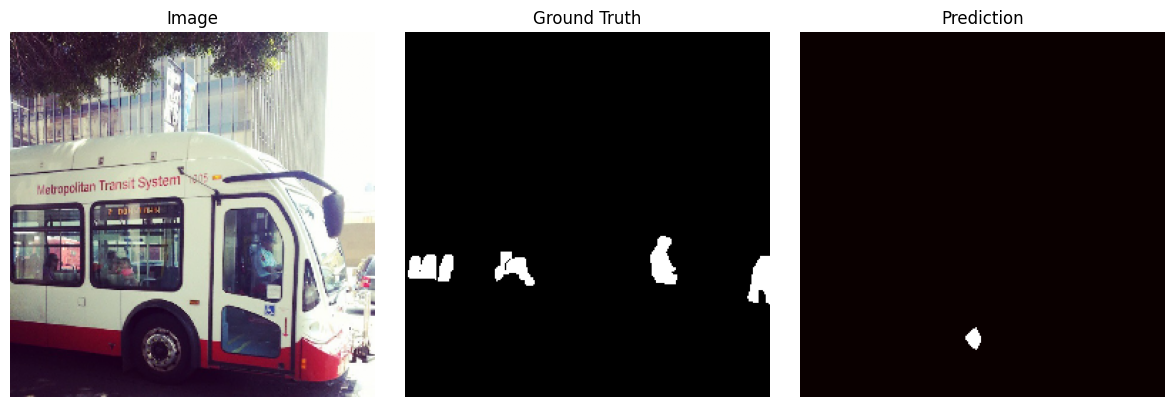

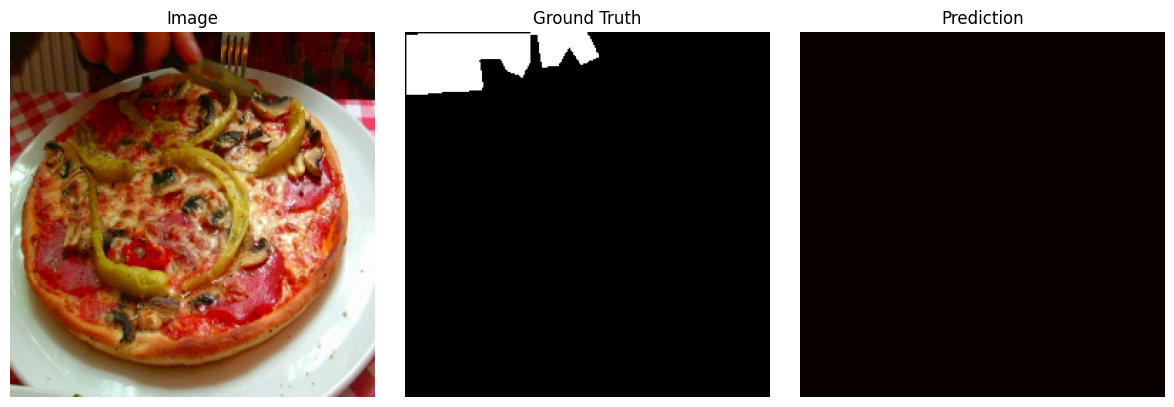

In [ ]:

import random
import numpy as np
import torch
import matplotlib.pyplot as plt



#  Evaluation & Visualization for 3 random validation samples
model.eval()
for idx in random.sample(range(len(val_ds)), 3):
    img_tensor, true_mask = val_ds[idx]

    # Add batch dimension and predict
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        pred_mask = torch.sigmoid(output)[0, 0].cpu().numpy()  # [H, W]

    # Ground truth mask to numpy
    true_mask_np = true_mask[0].numpy()  # Convert from (1, H, W)

    # # Compute metrics
    # iou, dice = iou_dice(pred_mask, true_mask_np)
    # print(f"Sample {idx} — IoU: {iou:.3f}, Dice: {dice:.3f}")

    # Plot Image, Ground Truth, Prediction
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Image
    axs[0].imshow(img_tensor.permute(1, 2, 0).cpu().numpy().clip(0, 1))  # [C,H,W] → [H,W,C]
    axs[0].set_title("Image")
    axs[0].axis('off')

    # Ground Truth
    axs[1].imshow(true_mask_np, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    # Prediction
    axs[2].imshow(pred_mask > 0.5, cmap='hot')
    axs[2].set_title("Prediction")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


# **Evaluation**

In [ ]:
import numpy as np
import torch

#  Evaluation with IoU & Dice Score for 3 Samples
def evaluate_model(model, dataloader, device, threshold=0.3, num_samples=3):
    model.eval()
    iou_scores, dice_scores = [], []
    outputs = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()

            for i in range(min(num_samples, x.size(0))):
                pred = preds[i].squeeze().cpu().numpy()
                gt = y[i].squeeze().cpu().numpy()

                # Ensure binary masks
                pred = (pred > 0.5).astype(np.uint8)
                gt = (gt > 0.5).astype(np.uint8)

                # Calculate metrics
                intersection = np.logical_and(pred, gt).sum()
                union = np.logical_or(pred, gt).sum()

                iou = intersection / (union + 1e-8)
                dice = 2 * intersection / (pred.sum() + gt.sum() + 1e-8)

                iou_scores.append(iou)
                dice_scores.append(dice)
                outputs.append((x[i].cpu(), gt, pred))

            break  # Only one batch for evaluation

    print(f" Evaluated {len(iou_scores)} samples")
    return iou_scores, dice_scores, outputs

#  Run evaluation
iou_scores, dice_scores, sample_preds = evaluate_model(model, val_dl, device)

#  Show scores
for i, (iou, dice) in enumerate(zip(iou_scores, dice_scores)):
    print(f"Sample {i+1} ➤ IoU: {iou:.3f}, Dice: {dice:.3f}")


 Evaluated 3 samples
Sample 1 ➤ IoU: 0.000, Dice: 0.000
Sample 2 ➤ IoU: 0.025, Dice: 0.048
Sample 3 ➤ IoU: 0.000, Dice: 0.000
